# Determining Connectivity of Telecommunication Networks

We implemented the IP model using an optimization software called **`Gurobi`** alongside the Python package **`networkx`** in order to manipulate graphs. 
Here is the quick summery of the code, with a lot of comments to make the model implementation easier to read. For details on the model itself, and the structure, reasoning and problem statement go to the paper, that is also available in [Github](https://github.com/Edelwy/dfg-project-math381). This write-up is meant purely to explain the implementation reasoning, the problem should be known to the reader prior to reading this.

First, we set up the environment and import packages. `networkx` is used for working with graphs and their elements, without having to implement the object structure ourselves. We used it mostly for working with nodes and edges and acquiring their neighbors, etc. The `gurobipy` package is crucial to our model as it is the core of solving the IP problem. It is wildly used for linear programming optimization. It provides 2 main algorithms, the barrier and the simplex method, but these are used for continuous models (real variable values), while we have integer programming (integer variable values). 

In [1]:
import gurobipy as gp # Used for the IP model.
import numpy as np # Used for basic math operations.
from gurobipy import GRB # Used for setting the model to integer programing.
import networkx as nx # Used for graph manipulation.
import matplotlib.pyplot as plt # Used for vizualization of graphs.
import pandas as pd # Used for the data parsing.
import copy # We need this when creating paths.
import random # For vizualization.
import matplotlib.colors as mcolors # For vizualization.
import time # For timing the execution.

plt.rcParams['figure.dpi'] = 200

In [2]:
# Function for reading the input.
# The input is in 2 spreadsheets one with links and one with nodes.
def parseInput(filepath):

    # We create a dataframe reading the input in a spreadsheed form.
    nodes_dataframe = pd.read_excel(filepath, sheet_name="nodes").to_numpy()
    edges_dataframe = pd.read_excel(filepath, sheet_name="links").to_numpy()

    house_nodes = [] # Initializing the list of nodes type house.
    manhole_nodes = [] # Initializing the list of nodes type manhole.
    splitter_nodes = [] # Initializing the list of nodes type splitte.
    edges = [] # Initializing the list of edges.

    # Reading the data from the spreadsheed and adding the nodes to 
    # their corresponding list, based on the type.
    for row in nodes_dataframe:
        node_type = row[1]
        if node_type == "PJ":
            manhole_nodes.append(row[0])
        if node_type == "TS":
            splitter_nodes.append(row[0])
        if node_type == "OS":
            house_nodes.append(row[0])
    
    # Adding the edges from the spreadshit to the list.
    for row in edges_dataframe:
        edges.append((row[1], row[2], row[3]))
        
    # Returning all four lists.
    return house_nodes, manhole_nodes, splitter_nodes, edges

In [3]:
# Function that creates a graph.
def createGraph(house_nodes, manhole_nodes, splitter_nodes, edges):
    G = nx.Graph() # Creating an empty networkx graph.

    # Adding all of the nodes.
    G.add_nodes_from(house_nodes) 
    G.add_nodes_from(manhole_nodes) 
    G.add_nodes_from(splitter_nodes) 

    # Adding all of the edges.
    for edge in edges: 
        G.add_edge(edge[0], edge[1], capacity=edge[2])
    return G

In [4]:
# Function that creates the variables.
def createVariables(model, G_directed):
    x = {} # Initializing an empty dictionary for storing the variables.
    # Iterating through first edges in junctions.
    for start in G_directed.edges(): 
        # Iterating through last edges in junctions.
        for end in G_directed.edges(start): 
            # If these 2 edges have a common middle 
            #node we add them to the dictionary.
            if end[1] != start[0] and start[1] == end[0]: 
                x[start, end] = \
                model.addVar(name=f"x[{start[0]} {start[1]} {end[1]}]", \
                            vtype=GRB.INTEGER)     
    return x

In [5]:
# Function for creating constraints.
# Creating constraints for the start cable bundles:
def createConstraints(model, G_directed, x, weights):
    # Fixed edge, the constraint of which we are using.
    for start in G_directed.edges():
        constr = 0 # Initialize the constraint.
        # All other possible junction from this fixed edge.
        for end in G_directed.edges(start):
            # Check if the variable is in the dictionary.
            if (start, end) in x:
                var_start = x[start, end]
                constr = constr + var_start # Add to the sum.
                model.addConstr(var_start >= 0) # Implicit constraint.
            # Check if the junction variable for the junction going
            # in the opposite direction is in the dictionary.
            if ((end[1], end[0]),(start[1], start[0])) in x:
                var_end = x[(end[1], end[0]),(start[1], start[0])]
                constr = constr + var_end # Add to the sum.
                model.addConstr(var_end >= 0) # Implicit constraint.

        # The sum of variables on the fixed edge must be equal to the
        # weight on that edge.
        constr = constr == weights[start]
        # In the case where the key is not in the dictionary,
        # The constraint will be 0 which equals false, we dont want that.
        if constr != False: 
            model.addConstr(constr)

In [6]:
# Setting the objective function.
def createObjective(model, house_nodes, x):
    min = 0 # Initialize the objective function.
    for (start, end), var in x.items(): # Iterate through variables.
        # If the start node of the junction and the end node of the junction
        # are both houses, then we add it to the sum.
        if start[0] in house_nodes and end[1] in house_nodes:
            min += var
    model.setObjective(min, sense = gp.GRB.MINIMIZE) 

In [7]:
# Finding the solution to our model.
def evaluateModel(model, solution_name, pool_solutions):
    model.setParam("OutputFlag", False) # We don't want an output printed.
    model.setParam(GRB.Param.PoolSearchMode, 2) # Mode for searching all optimal solutions.
    model.setParam(GRB.Param.PoolSolutions, pool_solutions) # Number of solutions saved.
    model.optimize() # Actually optimizing the model and finding the solution.
    model.write(f"{solution_name}.lp") # Write out the model.

In [8]:
# Function that changes name from "x[A B C]"" to "A B C".
def modifyVariableName(model):
    vars = {} # Empty dictionary of variables.
    for var in model.getVars():
        if var.xn != 0: # We only need junctions that connect.
            pathVarName = var.VarName.replace("x", "")
            pathVarName = pathVarName.replace("[", "").replace("]", "")
            vars[pathVarName] = int(var.xn)
    return vars

In [9]:
# A function that changes junction variables into paths.
def junctionsToPaths(model):
    # This function changes the name from IP variable names, to
    # just nodes in the junction so it is more readable in the path.
    # Name goes from "x[A B C]"" to "A B C".
    vars = copy.deepcopy(modifyVariableName(model))
    varsInPaths = set() # So we don't create paths from variables we already added.
    paths = [] # We will save paths created here.

    for firstVarKey, firstVarValue in vars.items(): 
        if(firstVarKey not in varsInPaths):
            firstNodes = firstVarKey.split(" ") # First three nodes of the path.
            path = [firstNodes[0], firstNodes[1], firstNodes[2]] # Add them.
            vars[firstVarKey] = firstVarValue - 1
            if vars[firstVarKey] == 0:
                varsInPaths.add(firstVarKey)

            # We are going through the variables until there are changes made,
            # to the path. Once no new path is added, we can be sure the path is done.
            change = True
            while change:
                change = False
                # We add an edge to the path under 4 different conditions.
                for varKey, varValue in vars.items():
                    if(varKey == firstVarKey): continue
                    nodes = varKey.split(" ") # Getting all 3 nodes out of the junction.

                    # We add to the front of the path and the direction 
                    # of the junction is the same as the path.
                    if path[0] == nodes[1] and path[1] == nodes[2]:
                        path.insert(0, nodes[0])
                        vars[varKey] = varValue - 1
                        if vars[varKey] == 0:
                            varsInPaths.add(varKey)
                        change = True
                    # We add to the front of the path and the direction 
                    # of the junction is the opposite as the path.
                    elif path[0] == nodes[1] and path[1] == nodes[0]:
                        path.insert(0, nodes[2])
                        vars[varKey] = varValue - 1
                        if vars[varKey] == 0:
                            varsInPaths.add(varKey)
                        change = True
                    # We add to the end ont of the path and the direction 
                    # of the junction is the same as the path.
                    elif path[-2] == nodes[0] and path[-1] == nodes[1]:
                        path.append(nodes[2])
                        vars[varKey] = varValue - 1
                        if vars[varKey] == 0:
                            varsInPaths.add(varKey)
                        change = True
                    # We add to the end ont of the path and the direction 
                    # of the junction is the opposite as the path.
                    elif path[-2] == nodes[2] and path[-1] == nodes[1]:
                        path.append(nodes[0])
                        vars[varKey] = varValue - 1
                        if vars[varKey] == 0:
                            varsInPaths.add(varKey)
                        change = True
            paths.append(path)
    return paths


In [10]:
# A helper function to darken the colour of the edges, so the vizualization
# looks more readable.
def darken_color(color, amount = 0.8): # amount is percantage.
    rgb = mcolors.hex2color(color) # Changing the format.
    hsv = mcolors.rgb_to_hsv(rgb) # Changing the format again.
    new_value = hsv[2] * amount # Darkening the colour.
    new_rgb = mcolors.hsv_to_rgb((hsv[0], hsv[1], new_value)) # Changing back the format.
    new_hex = mcolors.rgb2hex(new_rgb) # Changing back the format again.
    return new_hex

In [11]:
# A helper function for adding the edges to the multigraph with colors and edge angles.
def add_edge(G, a, b, edgeColor = 0):
    # If the edge is already in the graph we must ad an angle to the edge, so there is no overlap.
    if (a, b) in G.edges: 
        max_rad = max(x[2]['rad'] for x in G.edges(data=True) if sorted(x[:2]) == sorted([a,b]))
    else: # If the edge isn't in the graph it can be straight.
        max_rad = 0
    G.add_edge(a, b, rad=max_rad+0.1, color=edgeColor) # Adding the edge with angle and colour.

In [12]:
# Creates a multigraph for the vizualization of the solution.
def createMultigraph(house_nodes, manhole_nodes, splitter_nodes, paths):
    G_multi = nx.MultiDiGraph() # Creates an empty graph.
    G_multi.add_nodes_from(house_nodes) 
    G_multi.add_nodes_from(manhole_nodes) 
    G_multi.add_nodes_from(splitter_nodes) 

    # Creating random colours so we can use them for showing paths.
    valid_colors = list(mcolors.CSS4_COLORS.values())  # List of valid color names
    random.shuffle(valid_colors)
    
    # Iterating through pairs of colours and paths, and adding them to the graph.
    for color, path in zip(valid_colors[:len(paths)], paths):
        for i in range(len(path) - 1): # Going over each edge in the path.
            add_edge(G_multi, path[i], path[i+1], darken_color(color))
    return G_multi

In [13]:
# Function that vizualizes the graph.
# The specifications are for prettier output.
def visualizeGraph(G, pos, house_nodes, manhole_nodes, splitter_nodes, weights, ax=None):
    nx.draw_networkx_nodes(G, pos, house_nodes, node_shape='o', 
                           edgecolors="black", linewidths=0.5, ax=ax)
    nx.draw_networkx_nodes(G, pos, manhole_nodes, node_shape='s', 
                           edgecolors="black", linewidths=0.5, ax=ax)
    nx.draw_networkx_nodes(G, pos, splitter_nodes, node_shape='D', 
                           edgecolors="black", linewidths=0.5, ax=ax)
    nx.draw_networkx_edges(G ,pos, width=0.5, ax=ax)
    nx.draw_networkx_edge_labels(G, pos, edge_labels=weights, font_size=8, 
                                 font_family="serif", rotate=False, ax=ax)
    nx.draw_networkx_labels(G, pos, font_size=8, font_family="serif", ax=ax)

In [14]:
# Function that vizualizes the solution (multigraph).
# Each colour is a disjoint path.
# The specifications are for prettier output.
def visualizeMultigraph(G_multi, pos, house_nodes, manhole_nodes, splitter_nodes, ax=None):
    nx.draw_networkx_nodes(G_multi, pos, house_nodes, node_shape='o', 
                           edgecolors="black", linewidths=0.5, ax=ax)
    nx.draw_networkx_nodes(G_multi, pos, manhole_nodes, node_shape='s', 
                           edgecolors="black", linewidths=0.5, ax=ax)
    nx.draw_networkx_nodes(G_multi, pos, splitter_nodes, node_shape='D', 
                           edgecolors="black", linewidths=0.5, ax=ax)
    for edge in G_multi.edges(data=True):
        nx.draw_networkx_edges(G_multi, pos, 
                               edgelist=[(edge[0],edge[1])],
                               connectionstyle=f'arc3, rad = {edge[2]["rad"]}', 
                               width=1.0, arrowstyle="-", 
                               edge_color=edge[2]["color"], ax=ax)
    nx.draw_networkx_labels(G_multi, pos, font_size=8, font_family="serif", ax=ax)

In [15]:
# Checking if the solution has house-node-house paths.
def checkPaths(paths):
    for path in paths:
        has_manhole = False
        for node in path:
            # If a path has a manhole we stop the search
            # in this path and move on to the next one.
            if "M" in node:
                has_manhole = True
                break
        # If a path doesn't have a manhole we return false,
        # therefore the solution is not satisfactory.
        if not has_manhole:
            return False
    # If all paths had at least one manhole, we return true.
    return True
        

In [25]:
# Writing up the report of the model to the user.
def writeReport(model, paths, solNo, execution_time, junction_variables):
    report = "REPORT:\n"
    report += f"Number of solutions found: {model.SolCount}\n"
    report += f"This is the {solNo}. solution the model found.\n"
    report += f"Does this solution have a manhole in every path: {checkPaths(paths)}\n"
    report += f"Execution time: {execution_time:.4f} seconds."

    if junction_variables:
        report += "\nJUNCTION VARIABLES: \n"
        for var in model.getVars():
            if var.xn != 0:
                report += f"{var.VarName}: {var.xn}\n"

    report += "\nPATHS: \n"
    for i, path in enumerate(paths):
        paths_str = ", ".join(path)
        report += f"{i:3}: {paths_str}\n"
    print(report)
            

In [20]:
# These are the parameters of the model that can be changed.
visualize = True 
allow_all_paths = False
junction_variables = True
input_file = "Theoretical Examples/Example1.xlsx"
pool_solutions = 100000

REPORT:
Number of solutions found: 1008
This is the 0. solution the model found.
Does this solution have a manhole in every path: True
Execution time: 0.0350 seconds.\JUNCTION VARIABLES: 
Variable x[M0 S0 H1]: 1.0
Variable x[M0 S0 H4]: 1.0
Variable x[M1 S1 H2]: 1.0
Variable x[M1 S1 H3]: 1.0
Variable x[S0 S1 M1]: 2.0
Variable x[S1 S0 H0]: 1.0
Variable x[S1 S0 M0]: 1.0

PATHS: 
  0: M0, S0, H1
  1: M0, S0, H4
  2: M1, S1, H2
  3: M1, S1, H3
  4: H0, S0, S1, M1
  5: M1, S1, S0, M0



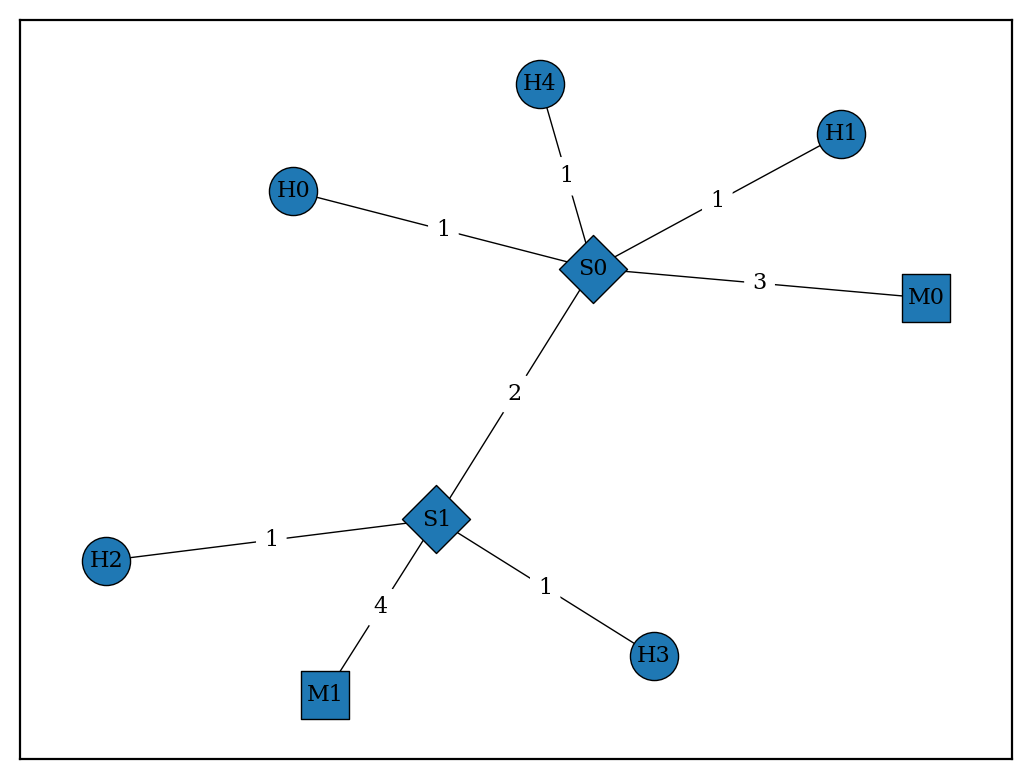

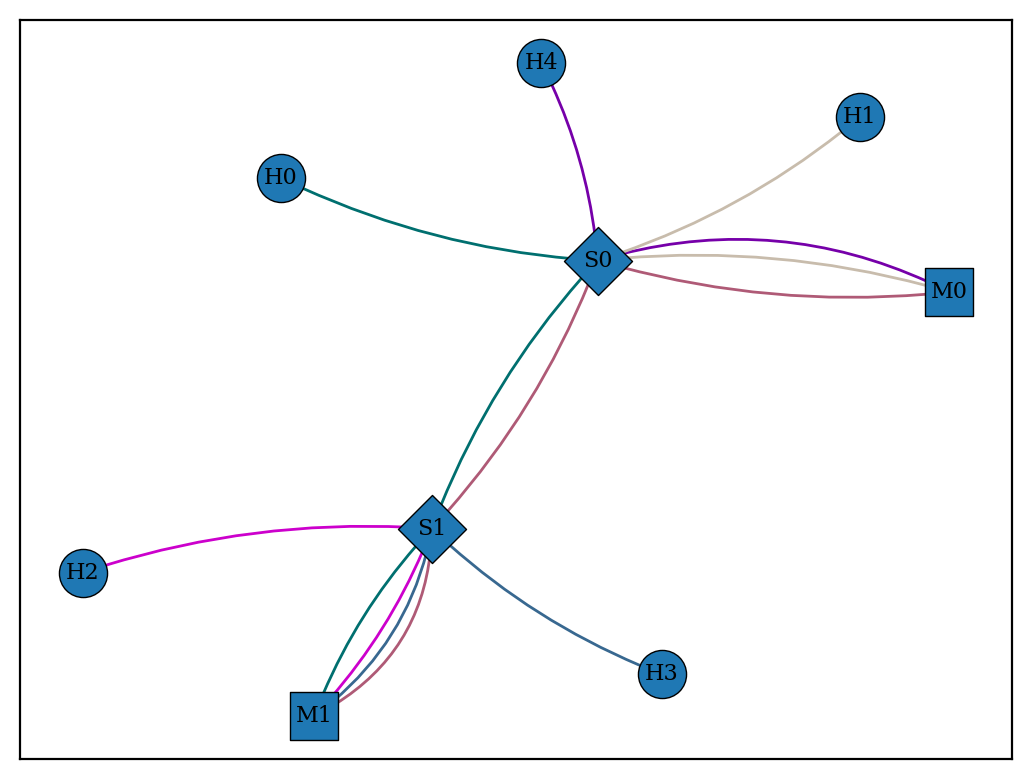

In [23]:
# Start the timer.
start_time = time.time()

# First we parse the input file provided in the arguments.
# From that we get nodes of type house, splitter and manhole.
# We also get edges and edge weights.
house_nodes, manhole_nodes, splitter_nodes, edges = parseInput(input_file)

# Then we create an undirected graph using these nodes and edges.
G = createGraph(house_nodes, manhole_nodes, splitter_nodes, edges)
G_directed = G.to_directed() # We also create a directed version of the graph.
# We extract the weights vector for all edges (directed).
weights = nx.get_edge_attributes(G_directed, 'capacity')
model = gp.Model("DFG") # Initialiting the model.

x = createVariables(model, G_directed) # Creating the variables vector.
createConstraints(model, G_directed, x, weights) # Adding constraints to the model.
createObjective(model, house_nodes, x) # Adding the objective function to the model.
evaluateModel(model, "DFG", pool_solutions=pool_solutions) # Evaluating the solution.
paths = junctionsToPaths(model) # Getting the paths of the model.

# If we don't want paths with house-node-house paths, we iterate through
# the solutions and find the first one that satisfies this constraint.
# If we dont find any we give a warning, that perhaps we should either save more
# solutions or lose the constraint.
solution_index = 0
if not checkPaths(paths) and not allow_all_paths:
    for i in range(1, model.SolCount):
        model.setParam(GRB.Param.SolutionNumber, i)
        paths = junctionsToPaths(model)
        path_check = checkPaths(paths)
        if path_check:
            solution_index = i
            break
        if not path_check and i == model.SolCount - 1:
            print("No solution with a manhole in every path found. \
                  Printing last solution saved. If this is not satisfactory \
                  consider increasing the number of solutions saved.")
            
# Getting the exection time.
end_time = time.time()
execution_time = end_time - start_time

#Printing out the report.
writeReport(model, paths, solution_index, execution_time, junction_variables)

# Vizualizing the input as an undirected graph and a solution as a multigraph.
if visualize:
    pos=nx.spring_layout(G)
    G_multi = createMultigraph(house_nodes, manhole_nodes, splitter_nodes, paths)
    visualizeGraph(G, pos, house_nodes, manhole_nodes, splitter_nodes, weights)
    plt.show()
    visualizeMultigraph(G_multi, pos, house_nodes, manhole_nodes, splitter_nodes)
    plt.show()